# **Coronary Heart Disease Prediction**
The main goal of this analysis it to  predict the coronary heart disease (chd: 1/0) for males in a heart-disease high-risk region of the Western Cape, South Africa.

**Dataset Overview:** 

**Target Variable:** chd (coronary heart disease: 1 means presence, 0 means absence).

**Features:** Nine predictors including continuous measures (e.g., systolic blood pressure, LDL cholesterol, adiposity, alcohol, age) and categorical/ordinal variables (e.g., family history (famhist), type-A behavior).


## Task 1: Exploratory Data Analysis

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, 
    classification_report, roc_curve, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


# Set plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### Data summary

In [3]:
# Load the dataset
df = pd.read_csv('heart-disease.csv')
print("Dataset Head:")
print(df.head())

# Display dataset info (data types, non-null counts)
print("\nDataset Info:")
print(df.info())

# Display basic descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values in each column
print("\nMissing Values:")
print(df.isnull().sum())

print(df['chd'].value_counts())


Dataset Head:
   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8  

#### **Class Imbalance**
- CHD(0)- 302
- CHD (1)- 160
This will be handled later during fitting the model.

### Visualisation 
- Histograms- To check the skewness of the continuous features
- Boxplots- To check the outliers present in the continous features
- Bar chart- For the categorical features like- famhist 
- Heatmap- Correlation Analysis -> To identify relationships among features

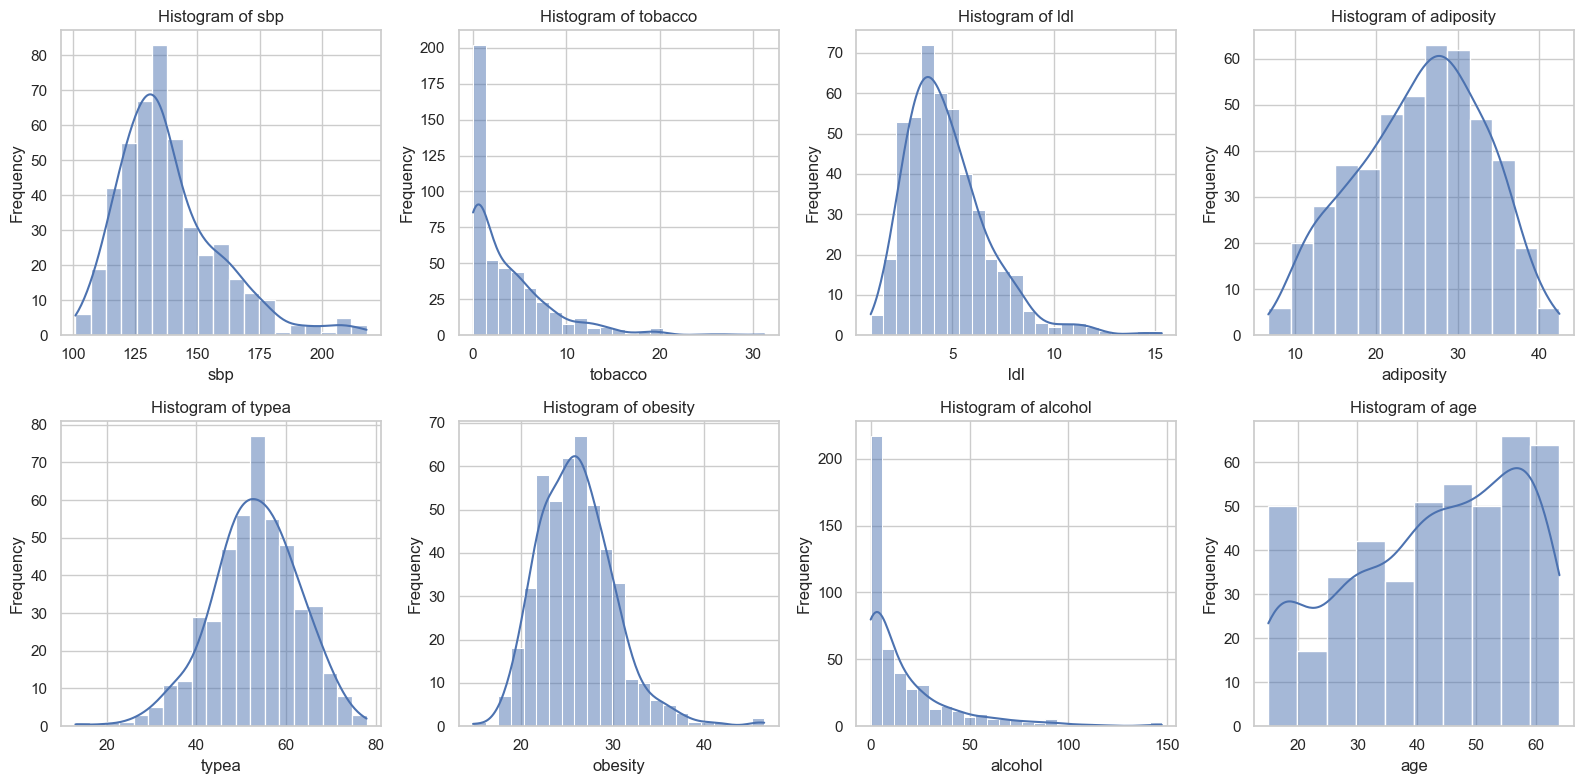

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define continuous features
continuous_features = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']

# Set up the figure and subplots (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns layout

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through features and plot histograms
for i, feature in enumerate(continuous_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



As a result, tobacco and alcohol are highly skewed (right-skewed). These two columns will need log transformation in the future before fitting the model. 

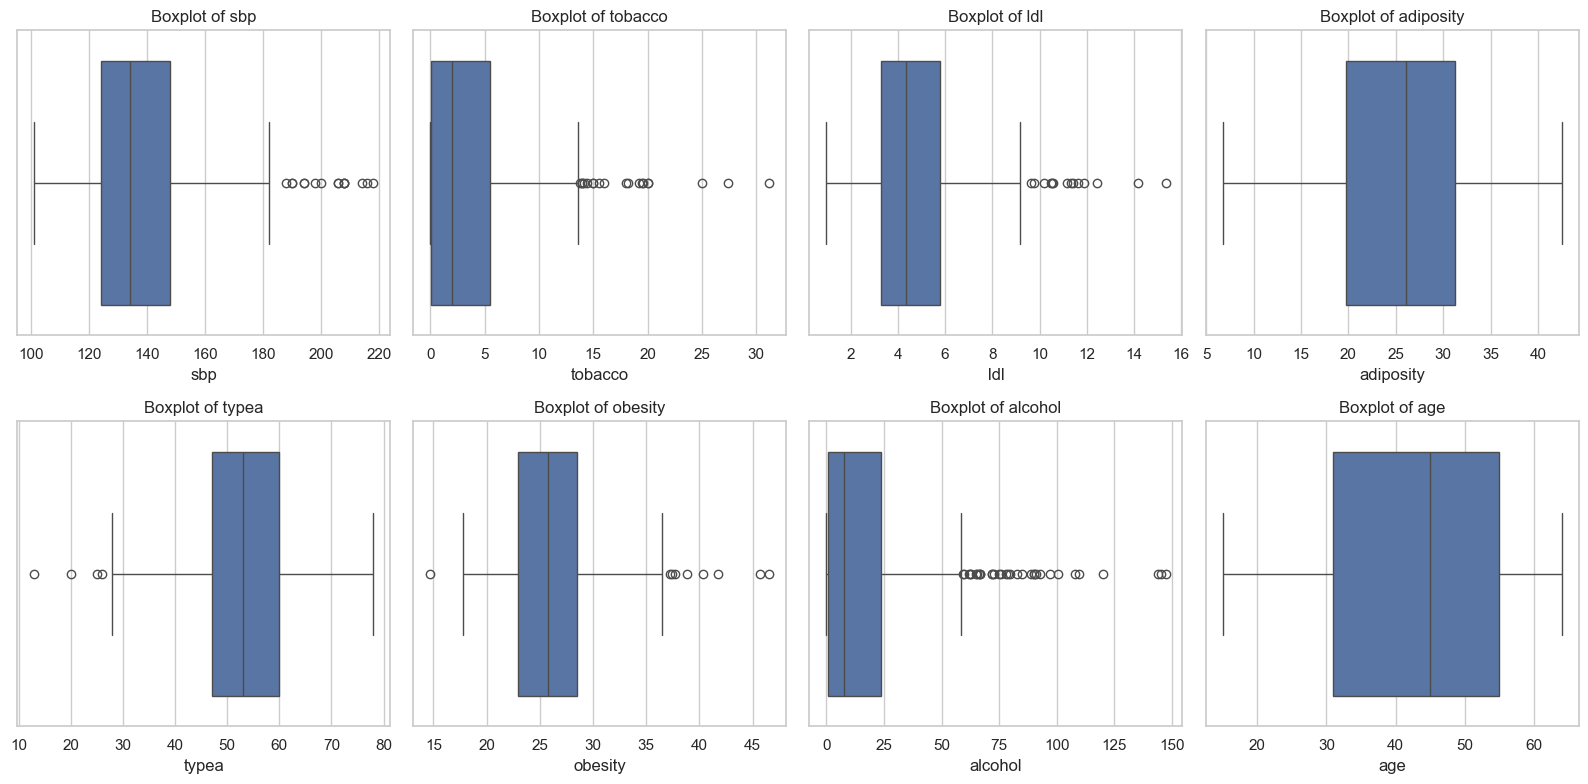

In [5]:
# Define continuous features
continuous_features = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']

# Set up the figure and subplots (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns layout

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through features and plot boxplots
for i, feature in enumerate(continuous_features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_xlabel(feature)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


#### Outlier Retention 

Outliers were detected across multiple features in the dataset. While extreme values are sometimes removed to improve model stability, in this case, they were **retained** as they might represent **high-risk individuals** who are more susceptible to CHD. Removing such observations could result in a loss of valuable information about the factors contributing to CHD.  

Since medical and lifestyle-related data often exhibit variability, certain extreme values may reflect real-world health risks rather than noise. By keeping these values, the model can **better capture the relationship between critical risk factors and CHD occurrence**, leading to a more **accurate prediction model**.  

To mitigate potential issues caused by extreme values, **feature scaling (StandardScaler) was applied**, ensuring that models sensitive to magnitude differences, such as logistic regression, are not disproportionately affected by large values.  


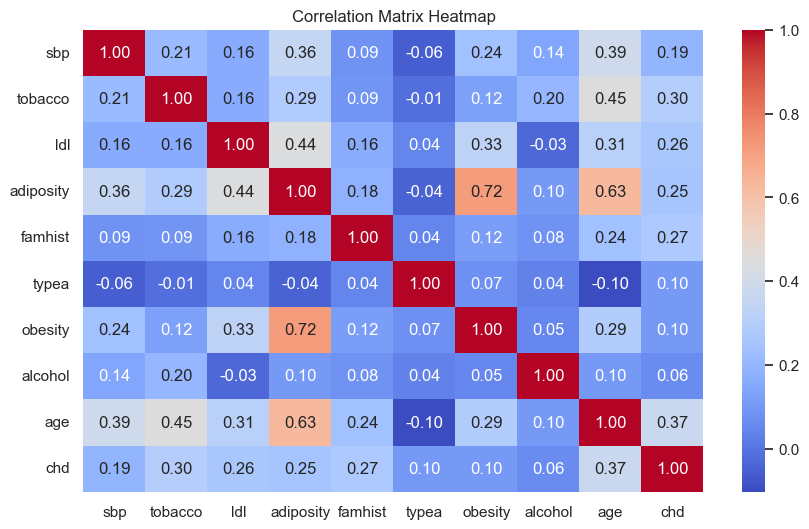

In [6]:
# d) Correlation Analysis: Correlation matrix heatmap
df_temp = df.copy()
df_temp['famhist'] = df_temp['famhist'].map({'Absent': 0, 'Present': 1})

plt.figure()
corr = df_temp.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()



#### **Key Insights:**
- **Age, Tobacco, LDL, and Family** History show moderate to strong correlation with CHD (above 0.25).  
- **Adiposity & Obesity (0.72)** → High correlation, suggesting redundancy.  
- **Age & Adiposity (0.63)** → Moderate correlation, but both could contribute unique information.  
- **LDL & Obesity (0.33)** → Suggests a relationship between cholesterol levels and obesity.  
- Features with a higher correlation with CHD are likely stronger predictors.  

### Building the Pipeline
- Handling categorical variables through encoding
- Applying the transformation to alocohol and tobacco columns because of their skewness (rightly-skewed)
- Scaling the dataset
- Fitting the Model

In [7]:
# a) Encode the categorical variable 'famhist'
df['famhist'] = df['famhist'].map({'Absent': 0, 'Present': 1})

In [8]:
# b) Log transformation for 'alcohol' and 'tobacco'
# Using np.log1p to safely transform (handles zeros)
df['alcohol'] = np.log1p(df['alcohol'])
df['tobacco'] = np.log1p(df['tobacco'])

In [9]:
# c) # Scale the continuous features
continuous_features = ['sbp', 'tobacco', 'ldl', 'adiposity', 
                       'typea', 'obesity', 'alcohol', 'age']

scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])
df

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1.058564,1.578588,0.478412,-0.295503,1,-0.418470,-0.176786,1.774774,0.629336,1
1,0.277089,-1.194338,-0.159680,0.412140,0,0.193344,0.671373,-0.564433,1.383115,1
2,-0.992806,-1.121611,-0.609245,0.884332,1,-0.112563,0.735519,-0.259415,0.218184,0
3,1.546985,1.117464,0.807126,1.624141,1,-0.214532,1.412621,0.859089,1.040488,1
4,-0.211332,1.704560,-0.599577,0.305351,1,0.703189,-0.012856,1.423603,0.423760,1
...,...,...,...,...,...,...,...,...,...,...
457,3.696039,-0.839965,0.599263,0.812281,0,1.111065,0.571590,-1.318688,1.040488,0
458,2.133091,0.584143,-0.159680,0.861173,0,-0.112563,0.609602,0.692116,0.629336,1
459,-1.481228,0.299400,-1.522877,-1.309364,0,-1.336191,-1.414575,0.919813,0.834912,0
460,-0.992806,0.809493,3.320823,0.692625,0,1.111065,0.310252,0.851302,-0.192969,0


## Task 2: Fitting the Model
### Logistic Regression with Ridge Penalty

In [10]:
#Splitting the dataset into train and test sets
# 'chd' is the target variable
X = df.drop('chd', axis=1)
y = df['chd']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [11]:
# ---------------------- BASELINE MODEL ----------------------
baseline_model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_base = baseline_model.predict(X_test)
y_pred_base_prob = baseline_model.predict_proba(X_test)[:, 1]

# Evaluation
baseline_acc = accuracy_score(y_test, y_pred_base)
baseline_auc = roc_auc_score(y_test, y_pred_base_prob)

In [12]:
print("Baseline Accuracy:", baseline_acc)
print("Baseline ROC-AUC:", baseline_auc)
print("Classification Report:\n", classification_report(y_test, y_pred_base))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_base))

Baseline Accuracy: 0.7050359712230215
Baseline ROC-AUC: 0.7630494505494505
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77        91
           1       0.57      0.58      0.58        48

    accuracy                           0.71       139
   macro avg       0.67      0.68      0.68       139
weighted avg       0.71      0.71      0.71       139

Confusion Matrix:
 [[70 21]
 [20 28]]


#### Key Observations

- **Accuracy:** 71% — Good overall performance.  
- **ROC-AUC:** 0.76 — Strong class separation.  
- **Recall (CHD):** 58% — Moderate ability to detect CHD cases.  
- **Precision (CHD):** 57% — Over half of predicted CHD cases were correct.  
- **Confusion Matrix Insight:** 28 TP, 20 FN — Misses some CHD patients.  
- **Summary:** Performs reasonably well, but recall could be improved for better CHD detection.




In [13]:
#Model Setup
#--------------Model with Hyperparameter Tuning---------------------
log_reg = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, class_weight='balanced')
param_grid = {'C': np.logspace(-3, 3, 7)}  # C: 0.001 to 1000

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred_tuned = best_log_reg.predict(X_test)
y_pred_tuned_prob = best_log_reg.predict_proba(X_test)[:, 1]

### Model Evaluation
- Accuracy
- ROC-AUC
- Confusion Matrix
- Classification report
-  Logistic regression coefficients

In [14]:
# Evaluation
tuned_acc = accuracy_score(y_test, y_pred_tuned)
tuned_auc = roc_auc_score(y_test, y_pred_tuned_prob)

print("Best parameter C:", grid_search.best_params_)
print("Tuned Accuracy:", tuned_acc)
print("Tuned ROC-AUC:", tuned_auc)
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

Best parameter C: {'C': 1.0}
Tuned Accuracy: 0.6906474820143885
Tuned ROC-AUC: 0.7653388278388279
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.63      0.73        91
           1       0.53      0.81      0.64        48

    accuracy                           0.69       139
   macro avg       0.70      0.72      0.69       139
weighted avg       0.75      0.69      0.70       139

Confusion Matrix:
 [[57 34]
 [ 9 39]]


#### Model Performance Metrics
- **Recall (CHD - Class 1): 0.81** → Excellent at identifying true CHD cases, minimizing false negatives — critical in medical diagnostics.
- **Precision (CHD): 0.53** → Moderate, indicating some false positives, but acceptable to avoid missing at-risk individuals.
- **Accuracy: 69%** → Indicates overall correct classification across both classes.
- **ROC-AUC: 0.765** → Suggests good discriminative ability between CHD and non-CHD cases.

#### Confusion Matrix Summary:
- **True Positives (TP): 39**
- **False Negatives (FN): 9** → Very low, shows strong sensitivity.
- **False Positives (FP): 34**
- **True Negatives (TN): 57**

**Overall summary** The model balances performance well, especially prioritizing recall for CHD — making it suitable for health-risk prediction where catching true cases is vital.



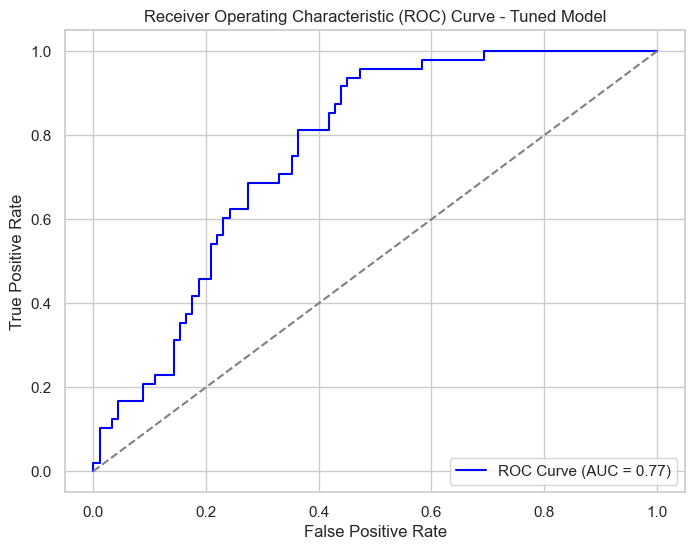

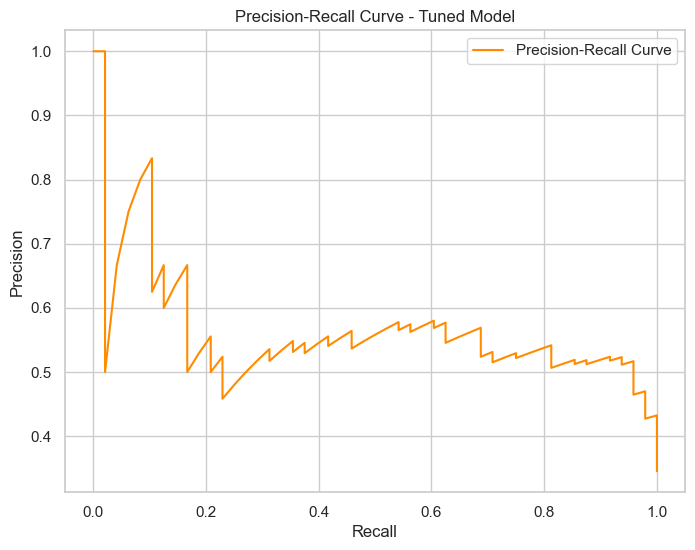

In [15]:
y_pred_prob_tuned = best_log_reg.predict_proba(X_test)[:, 1]

# ===== ROC Curve =====
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_tuned)
roc_auc = roc_auc_score(y_test, y_pred_prob_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Receiver Operating Characteristic (ROC) Curve - Tuned Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ===== Precision-Recall Curve =====
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_tuned)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', label="Precision-Recall Curve")
plt.title("Precision-Recall Curve - Tuned Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()

**ROC Curve (AUC = 0.77):**  
  Demonstrates good discriminatory power of the tuned logistic regression model. The curve stays well above the diagonal, indicating the model can distinguish between CHD and non-CHD cases effectively.
  
**Precision-Recall Curve:**  
  The model shows high precision at low recall values, gradually decreasing as recall increases. This suggests the model is reliable when predicting positive CHD cases with high confidence but may sacrifice some precision to capture more CHD cases (higher recall).
 
Both curves reflect strong model performance, especially in a medical context where high recall is critical. The model balances sensitivity (recall) and precision effectively.




In [16]:
# Coefficient Analysis for Logistic Regression
coefficients = best_log_reg.coef_[0]
features = X_train.columns

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df.sort_values('Abs_Coefficient', ascending=False, inplace=True)
print("\nLogistic Regression Coefficients (sorted by absolute value):")
print(coef_df[['Feature', 'Coefficient']])



Logistic Regression Coefficients (sorted by absolute value):
     Feature  Coefficient
8        age     0.737150
4    famhist     0.624162
2        ldl     0.532656
1    tobacco     0.386340
5      typea     0.318342
3  adiposity    -0.286061
0        sbp     0.104754
6    obesity     0.085348
7    alcohol    -0.037384


#### Logistic Regression Coefficients

- **Positive coefficients** (e.g., `age`, `famhist`, `ldl`, `tobacco`) indicate increased CHD risk.
- **Negative coefficients** (`adiposity`, `alcohol`) suggest inverse or weaker associations.
- **Most important predictors:**
  - **Age (0.737):** Strongest contributor to CHD risk.
  - **Family History (0.624):** Genetic predisposition plays a key role.
  - **LDL (0.533):** High cholesterol is a major risk factor.
  - **Tobacco (0.386):** Smoking increases CHD risk.


## Task 3: Exploring Other Classifiers

In [17]:
# Define features and target variable
X = df.drop('chd', axis=1)  # Features
y = df['chd']  # Target variable

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print confirmation
print("Data successfully split into training and testing sets.")


Data successfully split into training and testing sets.


In [18]:
def train_and_evaluate_model(model, param_grid, model_name):
    
    # Perform Grid Search to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    
    # Predict on test set
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print Results
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Test Accuracy: {accuracy:.4f}")
    if roc_auc is not None:
        print(f"Test ROC-AUC: {roc_auc:.4f}")
    print(f"\nClassification Report for {model_name}:\n", report)
    print(f"\nConfusion Matrix for {model_name}:\n", cm)

    return best_model


#### Decision Tree Classifier

In [19]:
# Define the model and hyperparameter grid
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Train and evaluate Decision Tree
best_dt = train_and_evaluate_model(dt_model, dt_param_grid, "Decision Tree")

Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Test Accuracy: 0.5914
Test ROC-AUC: 0.5976

Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.73      0.59      0.65        61
           1       0.43      0.59      0.50        32

    accuracy                           0.59        93
   macro avg       0.58      0.59      0.58        93
weighted avg       0.63      0.59      0.60        93


Confusion Matrix for Decision Tree:
 [[36 25]
 [13 19]]


**Key Observations:**
- Decision Tree is interpretable but **prone to overfitting**.
- **Low recall (59%)** for CHD cases → many true positives missed.
- **High variance** indicates sensitivity to training data → poor generalization.


#### Random Forest Classifier

In [20]:
# Define the model and hyperparameter grid
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Train and evaluate Random Forest
best_rf = train_and_evaluate_model(rf_model, rf_param_grid, "Random Forest")


Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Test Accuracy: 0.6667
Test ROC-AUC: 0.7177

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74        61
           1       0.51      0.56      0.54        32

    accuracy                           0.67        93
   macro avg       0.64      0.64      0.64        93
weighted avg       0.67      0.67      0.67        93


Confusion Matrix for Random Forest:
 [[44 17]
 [14 18]]


 **Key Observations:**
- **More stable than Decision Tree**, with better generalization.
- **Moderate recall (56%)** for CHD cases → better than Decision Tree but still misses some positives.
- **Balanced precision and recall**, making it a reliable overall classifier.
- **Higher ROC-AUC (0.7177)** indicates better class separation ability.


#### Support Vector Machine

In [21]:
# Define the model and hyperparameter grid
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Train and evaluate SVM
best_svm = train_and_evaluate_model(svm_model, svm_param_grid, "SVM")


Best Parameters for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Test Accuracy: 0.6882
Test ROC-AUC: 0.7828

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.83      0.66      0.73        61
           1       0.53      0.75      0.62        32

    accuracy                           0.69        93
   macro avg       0.68      0.70      0.68        93
weighted avg       0.73      0.69      0.70        93


Confusion Matrix for SVM:
 [[40 21]
 [ 8 24]]


#### Key Observations:
- **Highest ROC-AUC (0.7828)** among all models, indicating strong class separation.
- **Good recall (75%)** for CHD cases, meaning it captures most high-risk individuals.
- **Precision for CHD (53%)** is moderate, with some false positives.
- **Balanced performance** overall, making it a strong model for detecting CHD with fewer misclassifications.
 **Key Observations:**
  - **Performs worse than Random Forest** in accuracy and recall.
  - **More biased towards class 0 (No CHD)**, misclassifying CHD cases.
  - The polynomial kernel provides some flexibility but does not outperform tree-based models.

#### k Nearest Neighbors

In [22]:
# Define the model and hyperparameter grid with distance-based weighting
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['distance'],  # Using distance to give more weight to closer neighbors
    'metric': ['euclidean', 'manhattan']
}

# Train and evaluate KNN
best_knn = train_and_evaluate_model(knn_model, knn_param_grid, "KNN")


Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Test Accuracy: 0.6452
Test ROC-AUC: 0.6842

Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.73      0.72      0.73        61
           1       0.48      0.50      0.49        32

    accuracy                           0.65        93
   macro avg       0.61      0.61      0.61        93
weighted avg       0.65      0.65      0.65        93


Confusion Matrix for KNN:
 [[44 17]
 [16 16]]


**Key Observations:**
  - KNN struggles with **high-dimensional data**, leading to lower performance.
  - **Higher misclassification rate for CHD cases**, making it unreliable for medical predictions.
  - **Performs worse than Random Forest and Decision Tree** in both accuracy and AUC

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
lda_model = LinearDiscriminantAnalysis()
lda_param_grid = {}  # No hyperparameters to tune for LDA

best_lda = train_and_evaluate_model(lda_model, lda_param_grid, "LDA")
#automatically handles class imbalance

Best Parameters for LDA: {}
Test Accuracy: 0.6882
Test ROC-AUC: 0.8069

Classification Report for LDA:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75        61
           1       0.54      0.62      0.58        32

    accuracy                           0.69        93
   macro avg       0.66      0.67      0.67        93
weighted avg       0.70      0.69      0.69        93


Confusion Matrix for LDA:
 [[44 17]
 [12 20]]


**Key Observations:**
  - **Strong ROC-AUC score**, indicating it effectively separates CHD from non-CHD cases.
  - **Better recall (62%)** than Decision Tree and SVM.
  - **A good alternative if interpretability is a priority**.

In [24]:
# Train and Evaluate **Quadratic Discriminant Analysis (QDA)**
qda_model = QuadraticDiscriminantAnalysis()
qda_param_grid = {}  # No hyperparameters to tune for QDA

best_qda = train_and_evaluate_model(qda_model, qda_param_grid, "QDA")
#Automatically handles class imbalance

Best Parameters for QDA: {}
Test Accuracy: 0.6344
Test ROC-AUC: 0.7223

Classification Report for QDA:
               precision    recall  f1-score   support

           0       0.75      0.66      0.70        61
           1       0.47      0.59      0.53        32

    accuracy                           0.63        93
   macro avg       0.61      0.62      0.61        93
weighted avg       0.66      0.63      0.64        93


Confusion Matrix for QDA:
 [[40 21]
 [13 19]]


**Key Observations:**
  - **More complex than LDA**, but **does not outperform it**.
  - **Prone to overfitting** due to class-dependent variance assumptions.
  - **LDA is preferable for simpler and more stable predictions**.


In [25]:
# Train and Evaluate **Flexible Discriminant Analysis (FDA)**
fda_model = make_pipeline(PolynomialFeatures(degree=2), LinearDiscriminantAnalysis())
fda_param_grid = {"polynomialfeatures__degree": [2, 3, 4]}  # Tune degree of polynomials

best_fda = train_and_evaluate_model(fda_model, fda_param_grid, "FDA")
#Automatically handles the class imbalance

Best Parameters for FDA: {'polynomialfeatures__degree': 2}
Test Accuracy: 0.6774
Test ROC-AUC: 0.7223

Classification Report for FDA:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75        61
           1       0.53      0.56      0.55        32

    accuracy                           0.68        93
   macro avg       0.65      0.65      0.65        93
weighted avg       0.68      0.68      0.68        93


Confusion Matrix for FDA:
 [[45 16]
 [14 18]]


**Key Observations:**
  - **Adds non-linearity**, but does not improve performance significantly.
  - **Higher complexity than LDA but with minimal accuracy gains**.
  - **Not recommended over Random Forest or LDA**

In [26]:
# Train and Evaluate **Naïve Bayes (GaussianNB)**
nb_model = GaussianNB()
nb_param_grid = {}  # No hyperparameters to tune for GaussianNB

best_nb = train_and_evaluate_model(nb_model, nb_param_grid, "Naïve Bayes")
#Automatically  handles class imbalance

Best Parameters for Naïve Bayes: {}
Test Accuracy: 0.7204
Test ROC-AUC: 0.7597

Classification Report for Naïve Bayes:
               precision    recall  f1-score   support

           0       0.86      0.69      0.76        61
           1       0.57      0.78      0.66        32

    accuracy                           0.72        93
   macro avg       0.71      0.73      0.71        93
weighted avg       0.76      0.72      0.73        93


Confusion Matrix for Naïve Bayes:
 [[42 19]
 [ 7 25]]


**Key Observations:**
  - **Best recall (78%) for CHD cases**, meaning it correctly identifies the most at-risk patients.
  - **Lower precision (57%)**, leading to more false positives.
  - **Recommended if maximizing CHD detection is the primary goal**.

## Final Model Selection

### Best Model: Naïve Bayes

- **Highest Recall (0.78)** → Best at detecting CHD cases.
- **Good Accuracy (0.72)** → One of the highest among all models.
- **Strong ROC-AUC (0.7597)** → Indicates good overall model performance.
- Ideal for small datasets & imbalanced classes – Naïve Bayes works effectively with limited data, making it suitable for the 462 observations in your dataset.

| **Model**         | **Best Hyperparameters**                                                  | **Test Accuracy** | **ROC-AUC** |
|------------------|---------------------------------------------------------------------------|-------------------|-------------|
| Decision Tree     | `max_depth=None, min_samples_leaf=4, min_samples_split=2`                | 0.59              | 0.60        |
| Random Forest     | `max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50` | 0.67              | 0.72        |
| SVM               | `C=0.1, gamma='scale', kernel='poly'`                                     | 0.69              | 0.78        |
| KNN               | `metric='euclidean', n_neighbors=10, weights='distance'`                 | 0.65              | 0.68        |
| LDA               | *Default – No tuning required*                                            | 0.69              | 0.81        |
| QDA               | *Default – No tuning required*                                            | 0.63              | 0.72        |
| FDA               | `polynomialfeatures__degree=2`                                            | 0.68              | 0.72        |
| **Naïve Bayes**   | *Default – No tuning required*                                            | **0.72**          | **0.76**    |


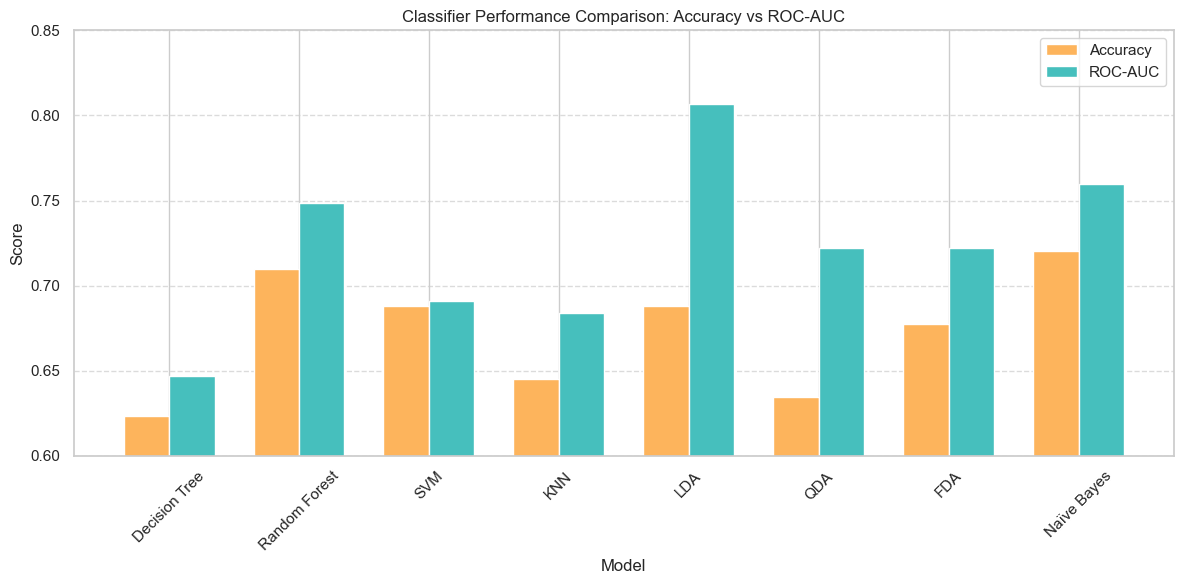

In [27]:
model_metrics = {
    'Decision Tree': {'Accuracy': 0.6237, 'ROC-AUC': 0.6470},
    'Random Forest': {'Accuracy': 0.7097, 'ROC-AUC': 0.7485},
    'SVM': {'Accuracy': 0.6882, 'ROC-AUC': 0.6911},
    'KNN': {'Accuracy': 0.6452, 'ROC-AUC': 0.6842},
    'LDA': {'Accuracy': 0.6882, 'ROC-AUC': 0.8069},
    'QDA': {'Accuracy': 0.6344, 'ROC-AUC': 0.7223},
    'FDA': {'Accuracy': 0.6774, 'ROC-AUC': 0.7223},
    'Naïve Bayes': {'Accuracy': 0.7204, 'ROC-AUC': 0.7597},
}

# Convert to DataFrame
df = pd.DataFrame.from_dict(model_metrics, orient='index').reset_index()
df.rename(columns={'index': 'Model'}, inplace=True)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
index = range(len(df))

# Accuracy and ROC-AUC bars
plt.bar(index, df['Accuracy'], bar_width, label='Accuracy', color='#FDB45C')
plt.bar([i + bar_width for i in index], df['ROC-AUC'], bar_width, label='ROC-AUC', color='#46BFBD')

# Plot styling
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Classifier Performance Comparison: Accuracy vs ROC-AUC')
plt.xticks([i + bar_width / 2 for i in index], df['Model'], rotation=45)
plt.ylim(0.6, 0.85)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


#### Key Insights from the Chart
- **Naïve Bayes**: Best overall balance — strong accuracy and ROC-AUC.
- **LDA**: Highest ROC-AUC, but slightly lower accuracy.
- **Random Forest**: Consistently good across both metrics.
- **SVM**: Moderate performance.
- **KNN, QDA, Decision Tree**: Weaker results, especially in ROC-AUC.

